# [Demo] Identification of the $\pi$ pulse

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ketbra}[2]{| #1 \rangle\langle #2 |}$

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
#os.environ['JAX_LOG_COMPILES'] = 'True'
import copy
import logging
import numpy as np
import scipy.optimize as sciopt
from scipy.fft import fft
import matplotlib.pyplot as plt
import rqutils.paulis as paulis
import qudit_sim
import qudit_sim.pulse as qpulse
from qudit_sim.parallel import parallel_map

try:
    os.mkdir('pi_pulse')
except FileExistsError:
    pass

unit_time = 0.2e-9

## System Hamiltonian

We will run the simulations in the ququadrit space and extract qutrit operators from the results.

In [2]:
hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=3.e+10, anharmonicity=-2.e+9, drive_amplitude=1.5e+9, qudit_id='q0')

## Effective Hamiltonian of a qubit-resonant drive

First we apply a constant drive and identify which terms are present in the ququadrit effective Hamiltonian. Here we cheat a bit and fix the nonresonant X and Y terms a priori (that they should be zero is obvious after looking at the generator evolution).

In [3]:
drive_frequency_01 = hgen.dressed_frequencies('q0')[0]
test_amplitude = 0.2

#init = dict((i, (0., True)) for i in [4, 5, 6, 7, 13, 14])
init = None

In [4]:
heff_test_01 = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_01, amplitude=test_amplitude,
                                        cycles=200, pulse_sim_solver='jax',
                                        optimizer_args=0.001, convergence=1.e-6, comp_dim=3,
                                        init=init, save_result_to='pi_pulse/res01')

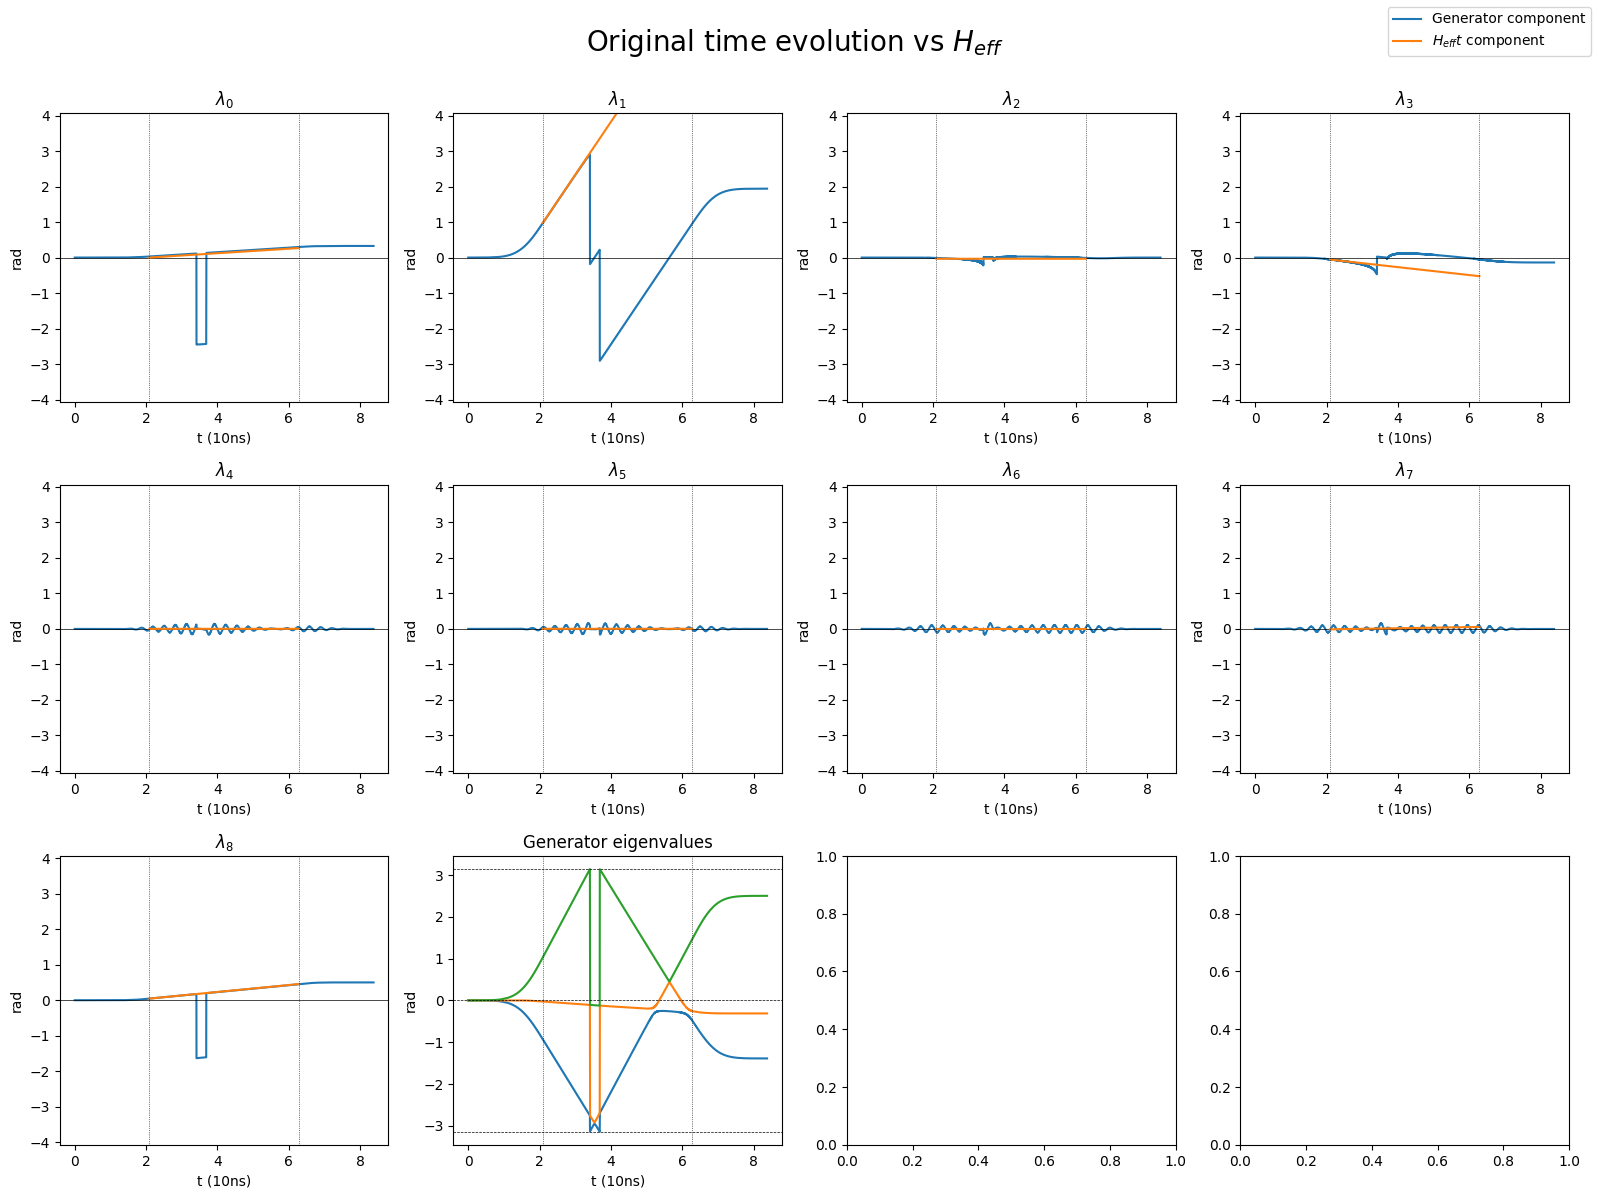

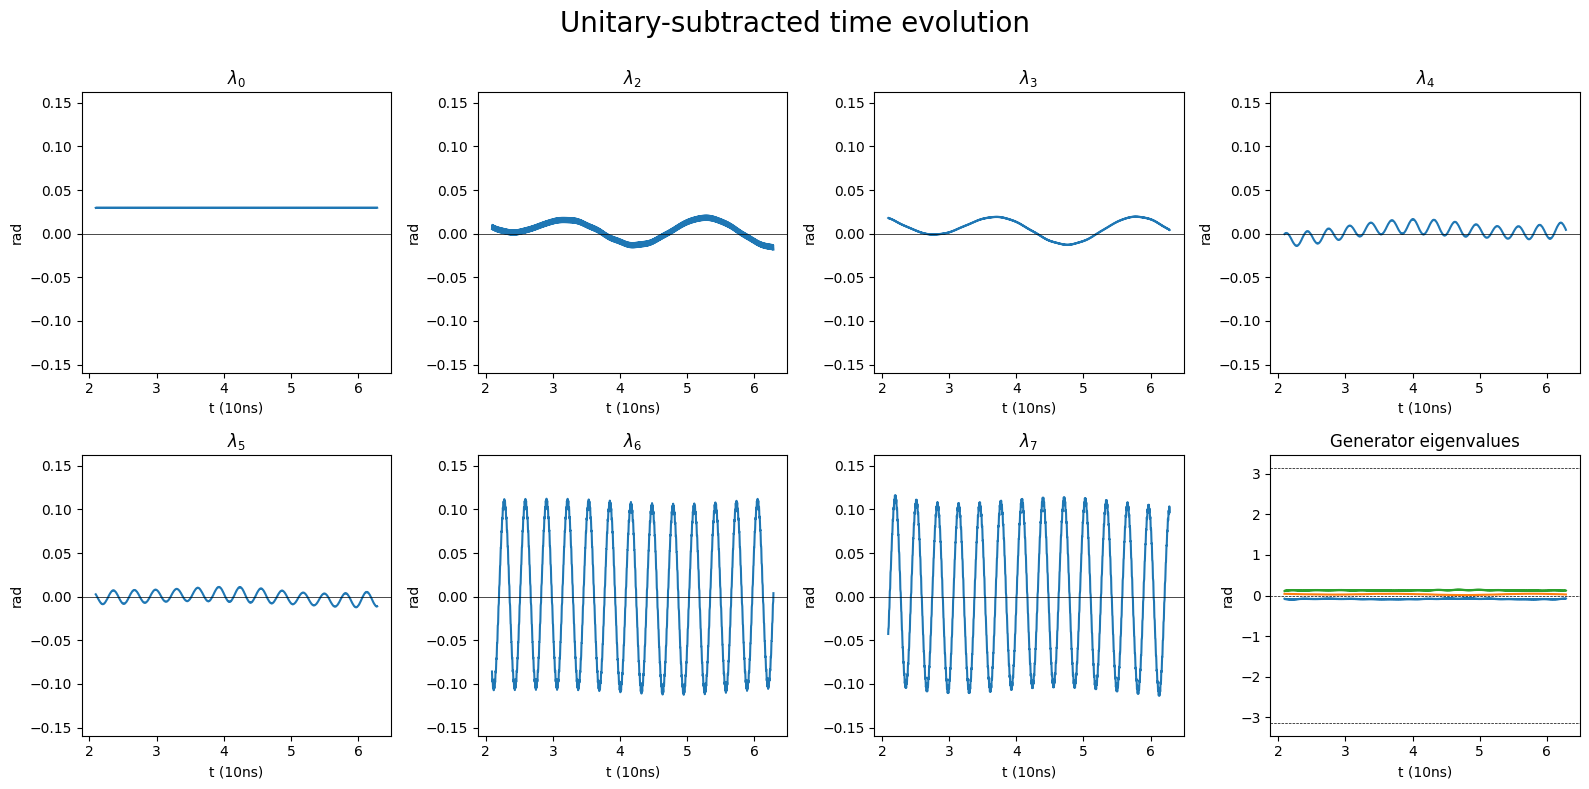

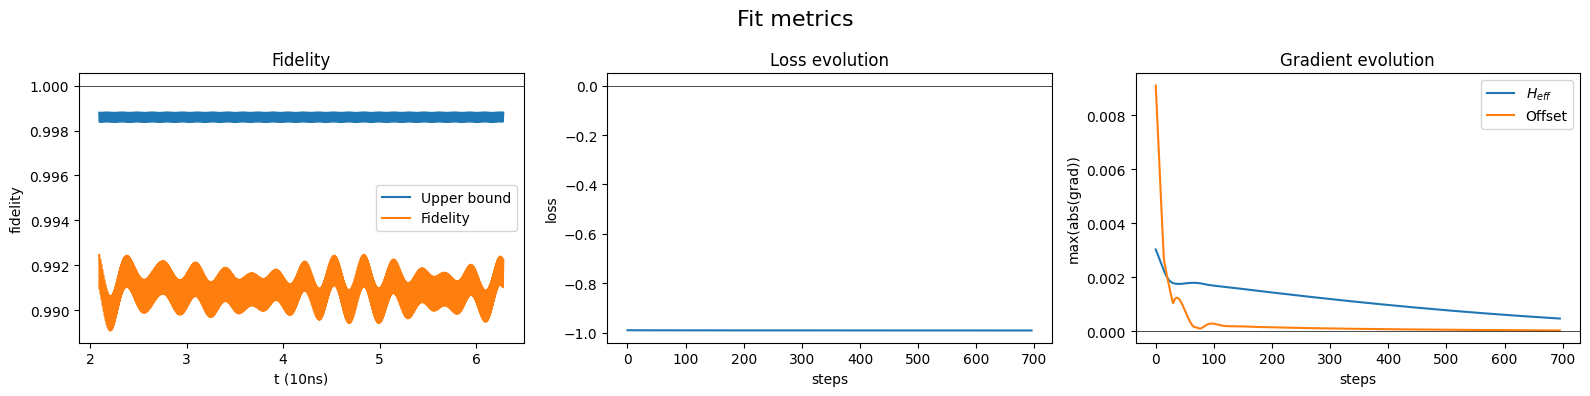

In [5]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res01.h5');

In [6]:
qudit_sim.visualization.print_components(heff_test_01, threshold=-0.01)

<IPython.core.display.Latex object>

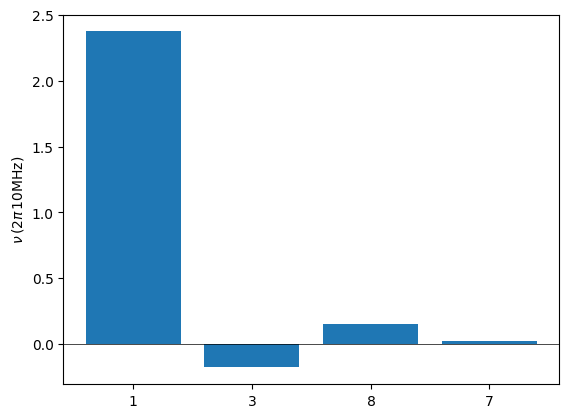

In [7]:
qudit_sim.visualization.plot_components(heff_test_01, threshold=-0.01);

## Gaussian pulse

We will ultimately find a DRAG pulse to implement $R_x(\pi)$, but we start with a Gaussian with a fixed duration and find the amplitude that gets us close to $\pi$.

In [8]:
hgen.clear_drive()

duration_01 = unit_time * 160
sigma_01 = unit_time * 40

This pulse has a line width of $1/\sigma = 125 \mathrm{Mrad/s}$ in the frequency domain, which means that the $\ket{1}\leftrightarrow\ket{2}$ transition frequency is 16 sigmas away.

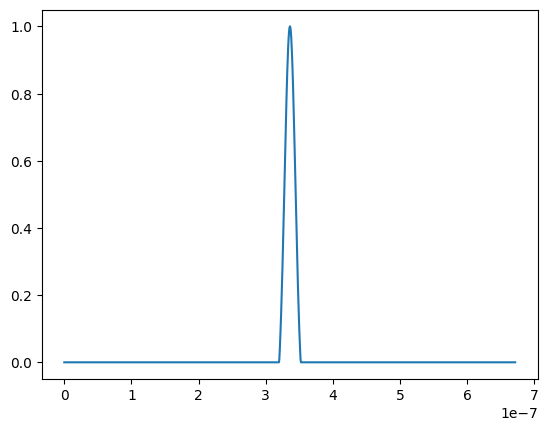

In [9]:
pulse_seq = qudit_sim.PulseSequence([
    qudit_sim.Delay(duration_01 * 10.),
    qpulse.Gaussian(duration=duration_01, amp=1., sigma=sigma_01),
    qudit_sim.Delay(duration_01 * 10.)
])

num_samples = 2**10

tpoints = np.linspace(0., 1., num_samples, endpoint=False) * pulse_seq.duration
time_domain = pulse_seq.envelope(tpoints).real
plt.plot(tpoints, time_domain);

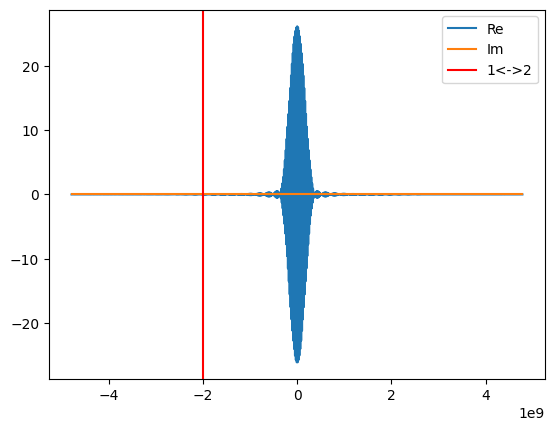

In [10]:
omegapoints = np.arange(-num_samples // 2, num_samples // 2).astype(float) * 2. * np.pi / pulse_seq.duration
frequency_domain = np.roll(fft(time_domain), num_samples // 2)
plt.plot(omegapoints, frequency_domain.real, label='Re')
plt.plot(omegapoints, frequency_domain.imag, label='Im')
q0 = hgen.qudit_params('q0')
plt.axvline(q0.anharmonicity, color='red', label='1<->2')
plt.legend();

In [11]:
# approximate the Gaussian with a triangle -> area = Heff * duration / 2
# pi/2 = (nu_X/test_amp*amp * duration / 2)
rough_amp_estimate = np.pi / 2. / (heff_test_01[1] / test_amplitude * duration_01 / 2.)
rough_amp_estimate

0.1316306485421348

In [12]:
amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 10)

heffs = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_01, amplitude=amplitudes,
                                 cycles=400, pulse_sim_solver='jax',
                                 optimizer_args=0.001, convergence=1.e-6, comp_dim=3)

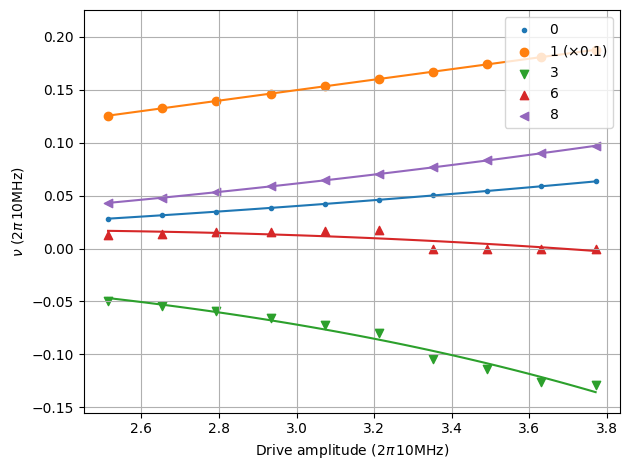

In [13]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, heffs);

In [14]:
amp = qudit_sim.Parameter('amp')
pulse = qpulse.Gaussian(duration=duration_01, amp=amp, sigma=sigma_01)

hgen.clear_drive()
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)

drive_args = list({'amp': a} for a in amplitudes)

sim_results = qudit_sim.pulse_sim(hgen, tlist=duration_01, drive_args=drive_args,
                                  final_only=True, solver='jax')

In [15]:
comp = qudit_sim.apps.gates.gate_components(sim_results[0], heffs[0] * (duration_01 / 2.))

In [16]:
guesses = list(heff * (duration_01 / 2.) for heff in heffs)
args = list(zip(sim_results, guesses))
#kwargs = {'convergence_window': 10, 'optimizer_args': 0.01}
components_list = parallel_map(qudit_sim.apps.gates.gate_components, args, thread_based=True)
components_list = np.array(components_list)

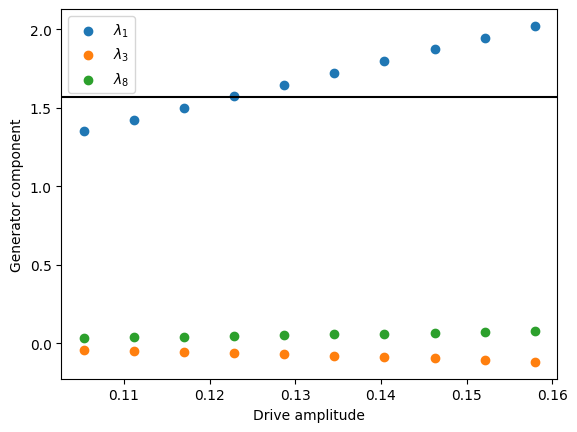

In [17]:
for i in [1, 3, 8]:
    plt.scatter(amplitudes, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(np.pi / 2., color='black')
plt.xlabel('Drive amplitude')
plt.ylabel('Generator component')
plt.legend();

Gaussian amplitude at which the X component hits $\pi/2$:

In [18]:
line = lambda x, slope, intercept: slope * x + intercept
popt, _ = sciopt.curve_fit(line, amplitudes, components_list[:, 1], p0=(0., 0.))

best_amplitude_01 = (np.pi / 2. - popt[1]) / popt[0]
best_amplitude_01

0.12261021897290432

Run the Gaussian pulse simulation again with this amplitude:

In [19]:
hgen.clear_drive()

pulse = qpulse.Gaussian(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)

sim_result = qudit_sim.pulse_sim(hgen, tlist=duration_01, final_only=True, solver='jax')

guess_01 = np.zeros(9)
guess_01[1] = np.pi / 2.

best_01_gaus_components = qudit_sim.apps.gates.gate_components(sim_result, guess_01, convergence=1.e-7)

In [20]:
qudit_sim.visualization.print_components(best_01_gaus_components, scale='pi')

<IPython.core.display.Latex object>

## DRAG pulse

The two-quadrature control (DRAG) can be used to create gate pulses that satisfy certain constraints. Here we aim to create a qubit X pulse, which means the phase error must be cast onto $\ket{2}$ alone, i.e., eliminate the $\lambda_3$ term.

References:

- Motzoi, Gambetta, Rebentrost, Wilhelm. "Simple pulses for elimination of leakage in weakly nonliear qubits", Phys. Rev. Lett., 103, 110501 (2009).
- Gambetta, Motzoi, Merkel, Wilhelm. "Analytic control methods for high-fidelity unitary operations in a weakly nonlinear oscillator", Phys. Rev. A, 83, 012308 (2011).

In [21]:
hgen.clear_drive()

beta = qudit_sim.Parameter('beta')

beta_guess = -0.5 / hgen.qudit_params('q0').anharmonicity
betas = np.linspace(0.5 * beta_guess, 2. * beta_guess, 20)

pulse = qpulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=beta)

hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)

drive_args = list({'beta': b} for b in betas)

sim_results = qudit_sim.pulse_sim(hgen, tlist=duration_01, drive_args=drive_args,
                                  final_only=True, solver='jax')

In [22]:
args = sim_results
common_args = (guess_01,)
components_list = parallel_map(qudit_sim.apps.gates.gate_components, args, common_args=common_args, thread_based=True)
components_list = np.array(components_list)

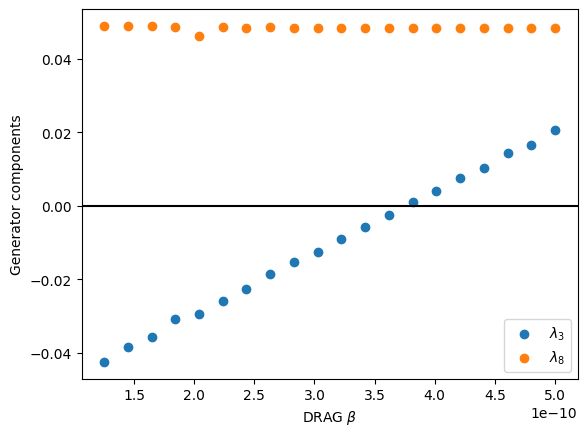

In [23]:
for i in [3, 8]:
    plt.scatter(betas, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(0., color='black')
plt.xlabel(r'DRAG $\beta$')
plt.ylabel('Generator components')
plt.legend();

$\beta$ parameter that eliminates $\lambda_3$:

In [24]:
popt, _ = sciopt.curve_fit(line, betas, components_list[:, 3], p0=(0., 0.))

best_beta_01 = (0. - popt[1]) / popt[0]
best_beta_01

3.769064842931069e-10

Running the full DRAG pulse simulation:

In [25]:
hgen.clear_drive()

pulse = qudit_sim.pulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=best_beta_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)

sim_result = qudit_sim.pulse_sim(hgen, tlist=duration_01, final_only=True, solver='jax')

best_01_drag_components = qudit_sim.apps.gates.gate_components(sim_result, guess_01)

In [26]:
qudit_sim.visualization.print_components(best_01_drag_components, scale='pi')

<IPython.core.display.Latex object>

## $\pi$ pulse for $\ket{1}\leftrightarrow\ket{2}$ transition

Let's go through the same exercise for $\ket{1} \leftrightarrow \ket{2}$.

In [27]:
hgen.clear_drive()

drive_frequency_12 = hgen.dressed_frequencies('q0')[1]
test_amplitude = 0.2

#init = dict((i, (0., True)) for i in [1, 2, 4, 5, 11, 12, 13, 14])
init = None

heff_test_12 = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_12, amplitude=test_amplitude,
                                        cycles=200, pulse_sim_solver='jax',
                                        optimizer_args=0.001, convergence=1.e-6, comp_dim=3,
                                        init=init, save_result_to='pi_pulse/res12')

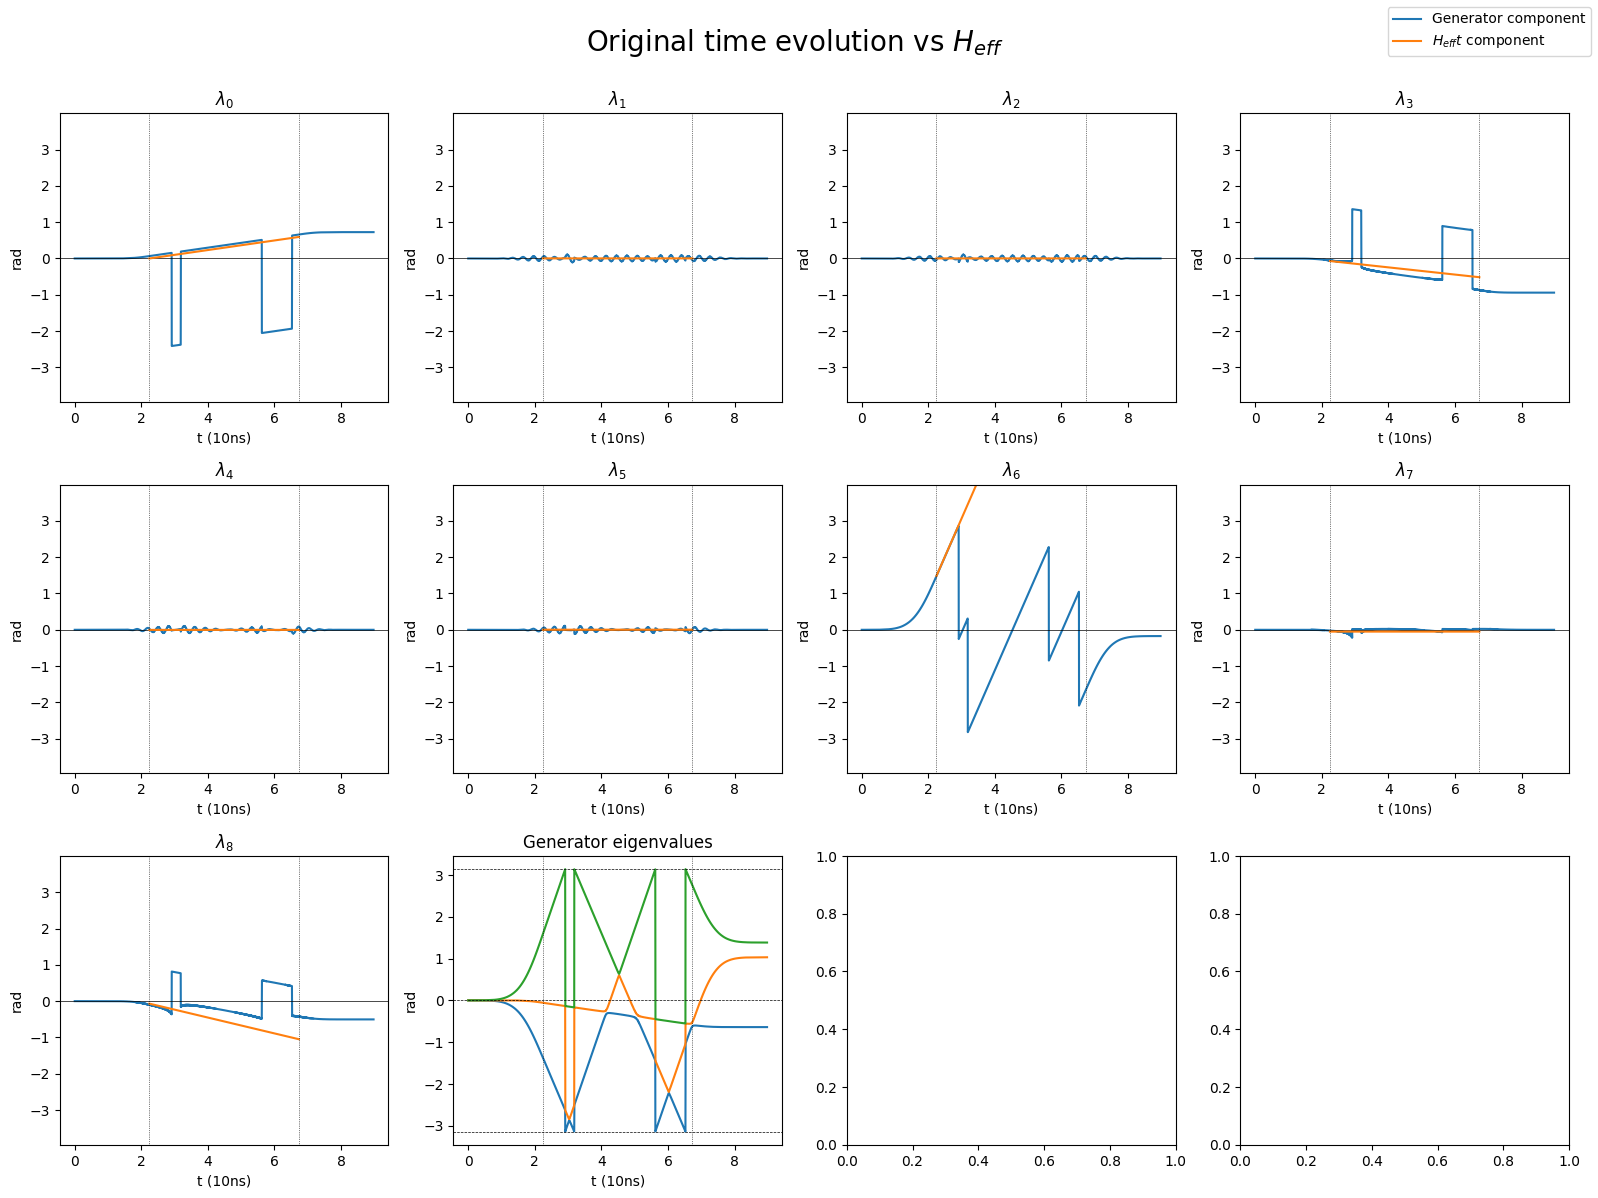

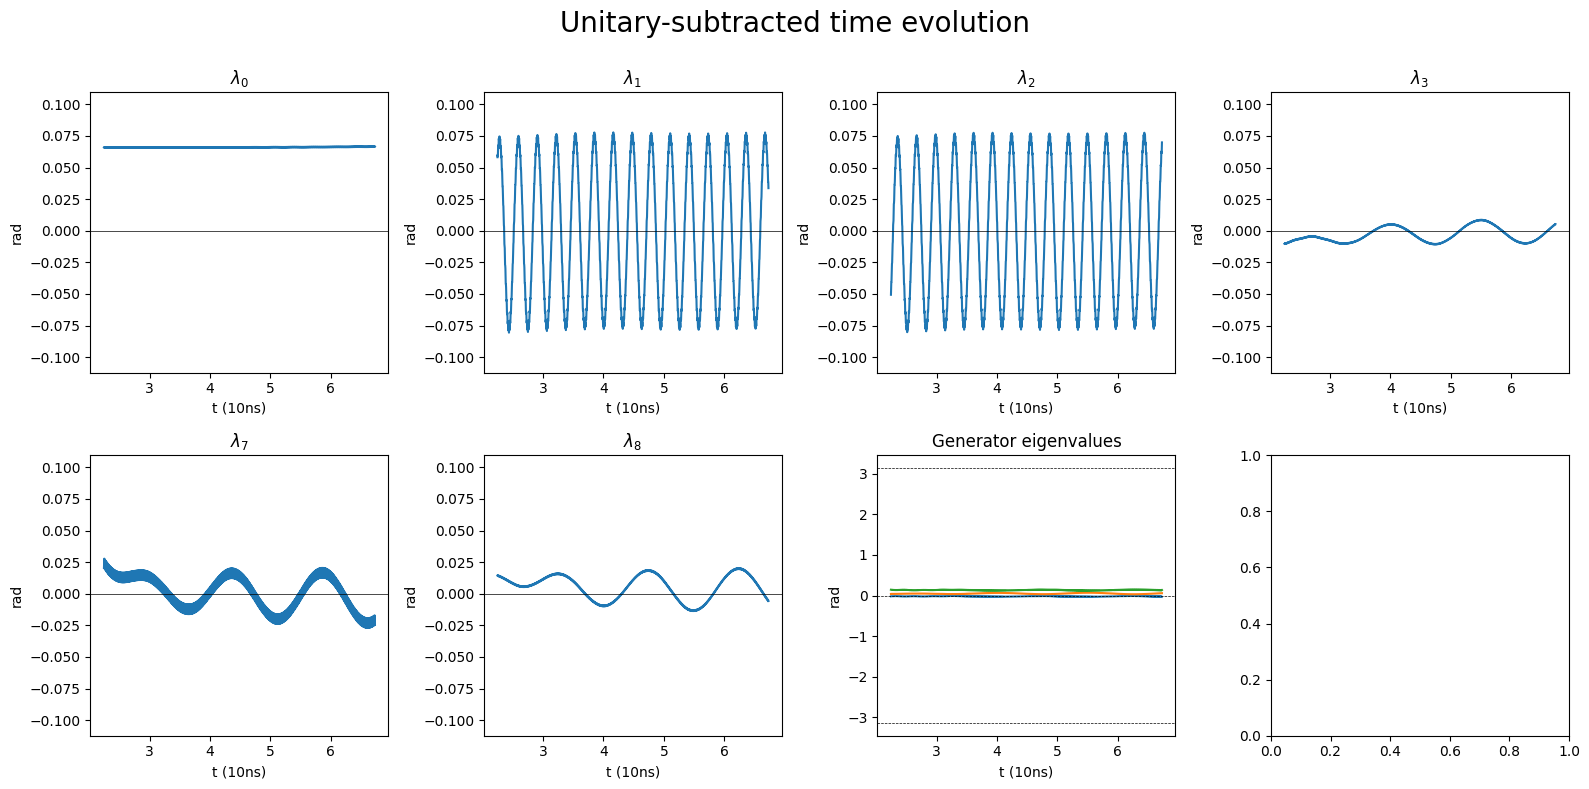

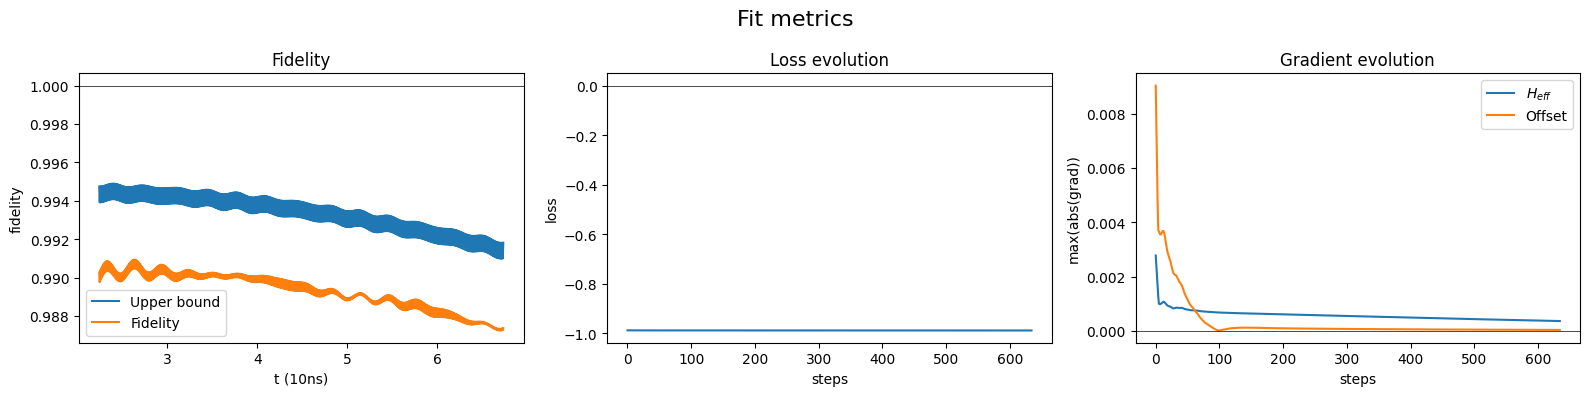

In [28]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res12.h5');

In [29]:
qudit_sim.visualization.print_components(heff_test_12)

<IPython.core.display.Latex object>

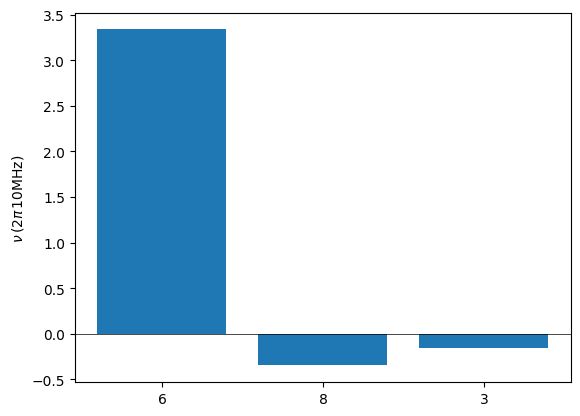

In [30]:
qudit_sim.visualization.plot_components(heff_test_12);

In [31]:
duration_12 = unit_time * 160
sigma_12 = unit_time * 40

In [32]:
hgen.clear_drive()

# approximate the Gaussian with a triangle -> area = amp * duration / 2.
rough_amp_estimate = np.pi / 2. / (heff_test_12[6] / test_amplitude * duration_12 / 2.)

amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 10)

heffs = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_12, amplitude=amplitudes,
                                 cycles=200, pulse_sim_solver='jax',
                                 optimizer_args=0.001, convergence=1.e-6, comp_dim=3)

In [33]:
hgen.clear_drive()

amp = qudit_sim.Parameter('amp')

pulse = qpulse.Gaussian(duration=duration_12, amp=amp, sigma=sigma_12)

hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)

drive_args = list({'amp': a} for a in amplitudes)

sim_results = qudit_sim.pulse_sim(hgen, tlist=duration_12, drive_args=drive_args,
                                  final_only=True, solver='jax')

In [34]:
guesses = list(heff * (duration_12 / 2.) for heff in heffs)

args = list(zip(sim_results, guesses))
components_list = parallel_map(qudit_sim.apps.gates.gate_components, args, thread_based=True)
components_list = np.array(components_list)

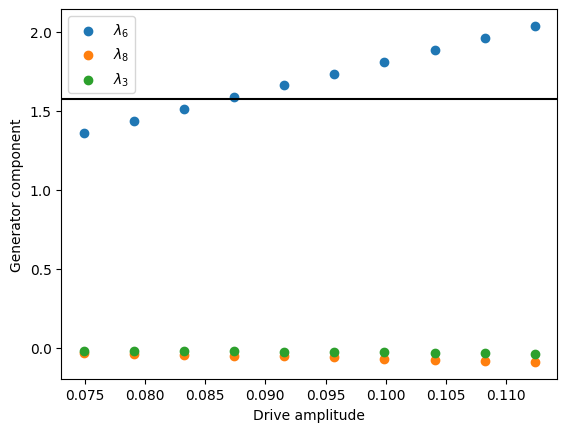

In [35]:
for i in [6, 8, 3]:
    plt.scatter(amplitudes, components_list[:, i], label=fr'$\lambda_{i}$')
plt.axhline(np.pi / 2., color='black')
plt.xlabel('Drive amplitude')
plt.ylabel('Generator component')
plt.legend();

In [36]:
popt, _ = sciopt.curve_fit(line, amplitudes, components_list[:, 6], p0=(0., 0.))

best_amplitude_12 = (np.pi / 2. - popt[1]) / popt[0]
best_amplitude_12

0.08671436362620007

In [37]:
hgen.clear_drive()

pulse = qpulse.Gaussian(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)

sim_result = qudit_sim.pulse_sim(hgen, tlist=duration_12, final_only=True, solver='jax')

guess_12 = np.zeros(9)
guess_12[6] = np.pi / 2.

best_12_gaus_components = qudit_sim.apps.gates.gate_components(sim_result, guess_12)

In [38]:
qudit_sim.visualization.print_components(best_12_gaus_components, scale='pi', basis='pauli1')

<IPython.core.display.Latex object>

Next we calibrate the DRAG to eliminate $\mathrm{diag}(0, 1, -1) = \frac{\sqrt{3}}{2} \lambda_8 - \frac{1}{2} \lambda_3 = \lambda_{3}^{(1)}$.

In [39]:
hgen.clear_drive()

beta = qudit_sim.Parameter('beta')

beta_guess = -0.5 / hgen.qudit_params('q0').anharmonicity
betas = np.linspace(0.5 * beta_guess, 2. * beta_guess, 20)

pulse = qpulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=beta)

hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)

drive_args = list({'beta': b} for b in betas)

sim_results = qudit_sim.pulse_sim(hgen, tlist=duration_12, drive_args=drive_args,
                                  final_only=True, solver='jax')

In [40]:
args = sim_results
common_args = (guess_12,)
components_list = parallel_map(qudit_sim.apps.gates.gate_components, args, common_args=common_args, thread_based=True)
components_list = np.array(components_list)
components_list = qudit_sim.change_basis(components_list, to_basis='pauli1', num_qudits=1).real

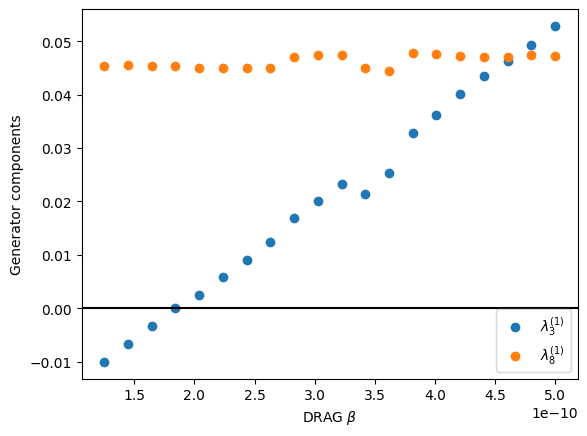

In [41]:
for i in [3, 8]:
    plt.scatter(betas, components_list[:, i], label=fr'$\lambda^{{(1)}}_{i}$')
plt.axhline(0., color='black')
plt.xlabel(r'DRAG $\beta$')
plt.ylabel('Generator components')
plt.legend();

In [42]:
popt, _ = sciopt.curve_fit(line, betas[:10], components_list[:10, 3], p0=(0., 0.))

best_beta_12 = (0. - popt[1]) / popt[0]
best_beta_12

1.8586918270752127e-10

Running the full DRAG pulse simulation:

In [43]:
hgen.clear_drive()

pulse = qudit_sim.pulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=best_beta_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)

sim_result = qudit_sim.pulse_sim(hgen, tlist=duration_12, final_only=True, solver='jax')

best_12_drag_components = qudit_sim.apps.gates.gate_components(sim_result, guess_12)

In [44]:
qudit_sim.visualization.print_components(best_12_drag_components, scale='pi', basis='pauli1')

<IPython.core.display.Latex object>

## Numerical optimization

$\pi$ pulse identification is actually automated in `apps.gates.pi_pulse`. This function directly constructs a DRAG pulse through numerical optimization (and is thus less instructive than this exercise):

In [45]:
drive_frequency, pi_pulse = qudit_sim.apps.gates.pi_pulse(hgen, 'q0', 1, duration=duration_12,
                                                          sigma=sigma_12,
                                                          pulse_sim_solver='jax')
print(pi_pulse)

Drag(duration=3.2e-08, amp=Constant((0.08656368371392038+0j)), sigma=8e-09, beta=Constant(1.8791802133003963e-10), center=1.6e-08, zero_ends=True)


In [46]:
hgen.clear_drive()

hgen.add_drive('q0', frequency=drive_frequency, amplitude=pi_pulse)

sim_result = qudit_sim.pulse_sim(hgen, tlist=pi_pulse.duration, final_only=True, solver='jax',
                                 log_level=logging.INFO)

components = qudit_sim.apps.gates.gate_components(sim_result, guess_12)

qudit_sim.visualization.print_components(components, scale='pi', basis='pauli1')

INFO:qudit_sim.pulse_sim:Using 2 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Starting simulation on JAX device 0.
INFO:qudit_sim.pulse_sim:Done in 1.10 seconds.


<IPython.core.display.Latex object>